In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\BRCA',
 'D:\\anaconda\\envs\\SPACEL\\python310.zip',
 'D:\\anaconda\\envs\\SPACEL\\DLLs',
 'D:\\anaconda\\envs\\SPACEL\\lib',
 'D:\\anaconda\\envs\\SPACEL',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python310\\site-packages',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\SPACEL\\lib\\site-packages\\Pythonwin']

In [2]:
import os
import matplotlib.pyplot as plt 
import SPACEL.Splane.utils
import pandas as pd
import scanpy as sc
import anndata as ad

print(os.getcwd())#显示当前路径
os.chdir('D:/bio/SPACEL/SPACEL-main')#更改路径，''里面为更改的路径
print(os.getcwd())#显示当前路径

D:\bio\jupyter_code\BRCA
D:\bio\SPACEL\SPACEL-main


In [3]:
sample_names = ["bc1160920F","bc1142243F"]
input_dir = 'G:/dataset/3_BRCA/input/'
output_dir = 'G:/dataset/3_BRCA/output/SPACEL/'
experiment_name = 'BRCA'

In [5]:
import scanpy as sc
import pandas as pd
adata_list = []

for dataset in sample_names:
    # adata = sc.read_visium(input_dir + dataset)
    # adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    
    adata = sc.read_h5ad(input_dir + dataset+'.h5ad')
    df = adata.obs[['x','y']].astype('float32')
    adata.obsm['spatial'] = df.values
    
    adata.obs['annotation'] = adata.obs['Classification']
    adata = adata[~pd.isna(adata.obs['x'])]
    adata_list.append(adata)


## Pairwise alignment
Here, we perform pairwise alignment of slices. The cluster_key is a column of .obs which contain spatial domain information used for alignment. The n_neighbors affect how much neighbors are considered when calculate similarity of two slices. The knn_exclude_cutoff affect max distance of neighbors. By default, knn_exclude_cutoff = n_neighbors, which means a spot/cell in source slices consider knn_exclude_cutoff neighbors in target slices, and neighbor will be exclude when the distance of neighbors larger than the median of neareast knn_exclude_cutoff + n_neighbors neighbors distance in all spot/cell in target slice. p affect the exponent of overlap penalty, and a larger p means stronger partial alignment capability.

In [6]:
from SPACEL import Scube
Scube.align(adata_list,
  cluster_key='Classification', 
  n_neighbors = 4, 
  p=1,
  write_loc_path = output_dir + experiment_name + '_aligned_coordinates.csv'
 )

# sc.concat(adata_list).write('../data/ST_mouse_brain/mouse_brain_st.h5ad')

D:\anaconda\envs\SPACEL\lib\site-packages\linear_operator\utils\deprecation.py:13: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  bool_compat = (torch.ones(1) > 0).dtype


Start alignment...
Alignment slice 1 to 0
Runtime: 156.14357089996338 s


In [ ]:
# type(adata_list[0].obs['Cell_class'].cat.categories)

In [7]:
for adata in adata_list:
    adata.obs['Classification'] = adata.obs['Classification'].astype("category")

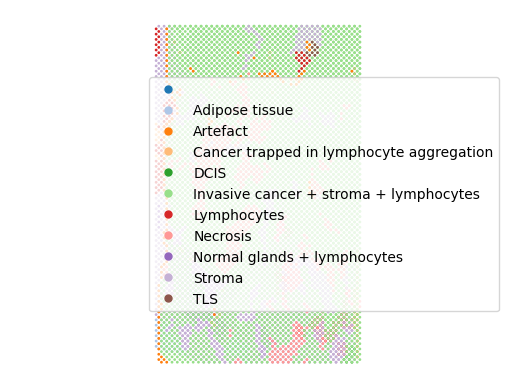

In [8]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial',cluster_key='Classification')
plt.savefig(output_dir + experiment_name + "_spatial.png", dpi=300)

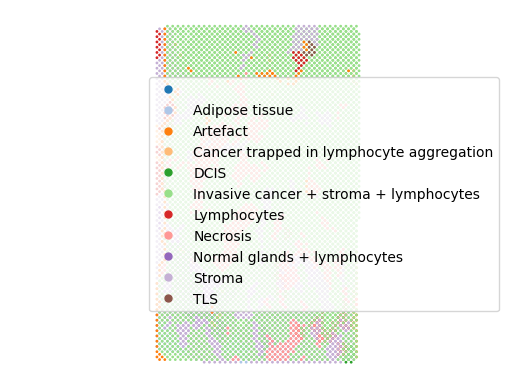

In [9]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial_pair',cluster_key='Classification')
plt.savefig(output_dir + experiment_name + "_spatial_pair.png", dpi=300)

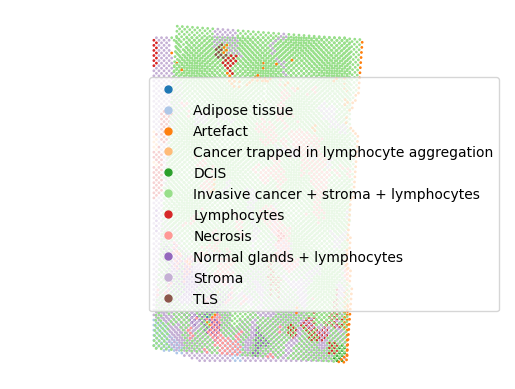

In [10]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial_aligned',cluster_key='Classification')
plt.savefig(output_dir + experiment_name + "_spatial_aligned.png", dpi=300)

In [12]:
# import seaborn as sns
# slice_colors = sns.color_palette(n_colors = 6).as_hex()
df = pd.DataFrame()
for i in range(len(adata_list)):
    df = pd.concat([df,adata_list[i].obs],axis=0)

series = df['Classification']
series = series.astype("category")

celltype_num = len(series.value_counts().index)
celltypes = series.value_counts().index.tolist()
print(celltype_num)

import seaborn as sns
colors = sns.color_palette("tab20", n_colors = celltype_num).as_hex()

print(colors)

11
['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b']


D:\anaconda\envs\SPACEL\lib\site-packages\SPACEL\Scube\plot.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(loc[:,0], loc[:,1], loc[:,2],c=color,*args,**kwargs)


G:/dataset/3_BRCA/output/SPACEL/BRCA_spatial_aligned_3d.png


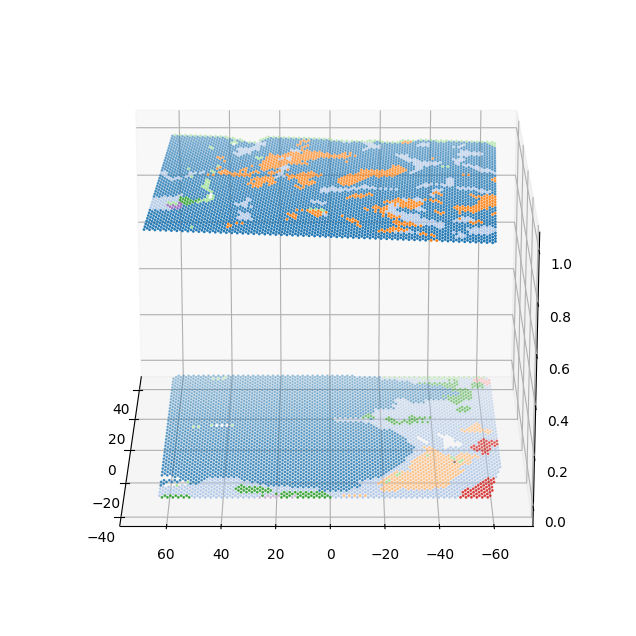

In [13]:
coo = pd.DataFrame()
for i in range(len(adata_list)):
    loc = adata_list[i].obsm['spatial_aligned'].copy()
    loc['Z'] = i
    loc['celltype_colors'] = adata_list[i].obs['Classification'].replace(dict(zip(celltypes, colors)))
    coo = pd.concat([coo,loc],axis=0)
path = output_dir + experiment_name + "_spatial_aligned_3d.png"
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=20,azim=180,s=1,save_path=path, save_dpi=300)

In [14]:
print(adata.raw.var)
# adata.raw.var.columns = ['gene']

           _index
0      AL627309.1
1      AL627309.3
2      AL627309.5
3      AP006222.2
4      AL732372.1
...           ...
28397  AC136352.3
28398  AC136616.1
28399  AC007325.1
28400  AC007325.4
28401  AC007325.2

[28402 rows x 1 columns]


In [15]:
for i in range(len(adata_list)):
    adata = adata_list[i]
    dataset = sample_names[i]
    adata.raw.var.columns = ['gene']
    print(adata.isbacked)
    adata.filename = output_dir + 'SPACEL_aligned_' + dataset + '.h5ad'
    print(adata.isbacked)

False
True
False
True
